<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite-Difference Method - Advection equation 1D</div>
        </div>
    </div>
</div>

# Advection equation 1D

This notebook covers the following aspects: 

* implementation of the 1D advection equation
* solved using the upwind or the centred finite difference scheme 
* study the stability of the two methods when solving the one-dimensional advection equation
* implementation of the Predictor-corrector method, McCormack scheme and Lax Wendroff Scheme

Programming exercise: 

* Add an analytical solution to the numerical solution and plot them both at the same time. The analytical solution is simply the shift of the initial waveform by $v*t$ where $v$ is the advection velocity and $t$ is the simulation time. 

---

## Advection Equation

The source-free advection equation is given by

$$
\partial_t u(x, t) + v \partial_x u(x, t) = 0
$$

where $u(x,t = 0)$ is a displacement waveform at $t = 0$ (an initial condition) that is advected with velocity $v$. 

## Numerical Solution using the Finite Differences Method

The Finite Difference Method allow us to solve this equation numerically. In this notebook it is used four schemes, first the Euler method, which is highly diffusive, second the predictor-corrector method or Heun's method and finally the McCormak scheme and the Lax Wendroff scheme. 

### Euler method

The Euler's method is the most basic method for numerical integration to solve first order degree differential equations with an initial condition. The general formula is the following, 
$$
u_{n+1} = u_n + \Delta t f(u_n, t_n)
$$
where $u$ is the velocity field, $t$ is the time, $h$ is the step and $f$ is the linear operator on the right hand side of the advection equation, in this case is $f(u_n, t_n) =  - v \partial_x u(x, t)$. 
The linear operator is a partial derivative in the space domain $x$, which is calculated using the centred or the backward finite difference scheme. 

### Centred finite-difference scheme

This scheme is used to solve parabolic partial differential equations, although the advection equation is an hyperbolic equation, this method is applied in this notebook in order to see how the output behaves. It gives an unstable solution, and it can be fixed adding an additional viscosity term (see bellow the Lax Wendrof approximation). 
Discretizing the advection, equation using the centred scheme we obtain,  

$$
\dfrac{u_i^{n+1}-u_i^n}{\Delta t}+
v\frac{u_{i+1}^{n}-u_{i-1}^n}{2\Delta x}=
0
$$

leading to the equation, 

$$
u_{i}^{n+1}=
u_{i}^{n}-
v\frac{\Delta t}{2\Delta x}
\left(u_{i+1}^{n}+u_{i-1}^{n}\right)
$$.

### Upwind finite difference scheme

The Upwind finite difference scheme is a numerical approach for hyperbolic partial differential equations, like the advection equation. It discretizes the equations using the difference with the previous step and the direction of propagation is determined by the sign of the velocity. In this case the advection equation looks like 

$$
\dfrac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}+
v\dfrac{u_{i}^{n}-u_{i-1}^{n}}{\Delta x}=
0
$$

which provides the equation, 

$$
u_{i}^{n+1}=u_{i}^{n}-
v\dfrac{\Delta t}{\Delta x}
\left(u_{i}^{n}+u_{i-1}^{n}\right)
$$.

In [1]:
import warnings

import matplotlib.pylab as plt
import numpy as np

In [2]:
# %matplotlib widget

# Show Plot in The Notebook
# plt.switch_backend("nbagg")

warnings.filterwarnings("ignore")

In [3]:
# PARAMATER CONFIGURATION
# ---------------------------------------------------------------------------
nx = 1250  # Number of grid points.
v = 5500.0  # Acoustic velocity in m/s.
x_max = 10000  # Length of the domain in m.
eps = 0.9  # CFL
tmax = 1.0  # Simulation time in s
isnap = 2  # Plot the solution each `isnap` timesteps.
sig = 100  # Sigma for the gaussian source time function
x0 = 1000  # Center point of the source time function

In [4]:
# INITIALIZE COORDINATES AND SET UP THE MODEL

# Choose between the finite difference scheme: "upwind" or a "centered"
# -------------------------
fd_type = "upwind"
# fd_type = "centered"


# Spatial setup
# -------------------------
x = np.linspace(0, x_max, nx)
dx = x[1] - x[0]

# Use wave based CFL criterion, time step will be calculated from stability criterion
dt = eps * dx / v

# Simulation time
# -------------------------
nt = int(tmax / dt)

# Initial condition in space
# -------------------------
sx = np.exp(-1.0 / sig**2.0 * (x - x0) ** 2.0)

# Initialize fields
# -------------------------
u = sx
unew = np.zeros(nx)
du = np.zeros(nx)
k1 = np.zeros(nx)
k2 = np.zeros(nx)
q = np.zeros(nx)

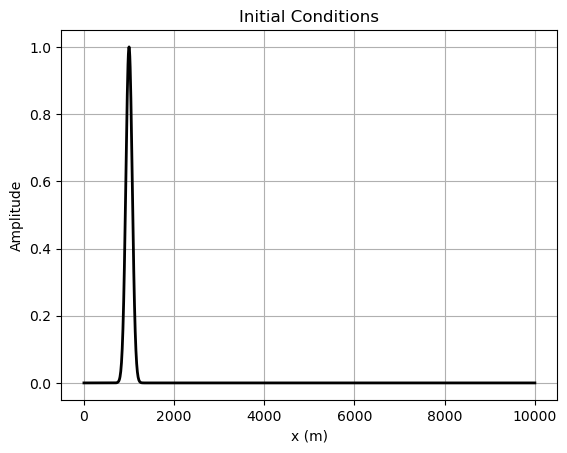

In [6]:
# Plot the initial conditions
plt.close()
plt.figure()
plt.title("Initial Conditions")
plt.grid()
plt.plot(x, u, color="black", lw=2)
plt.xlabel("x (m)")
plt.ylabel("Amplitude");

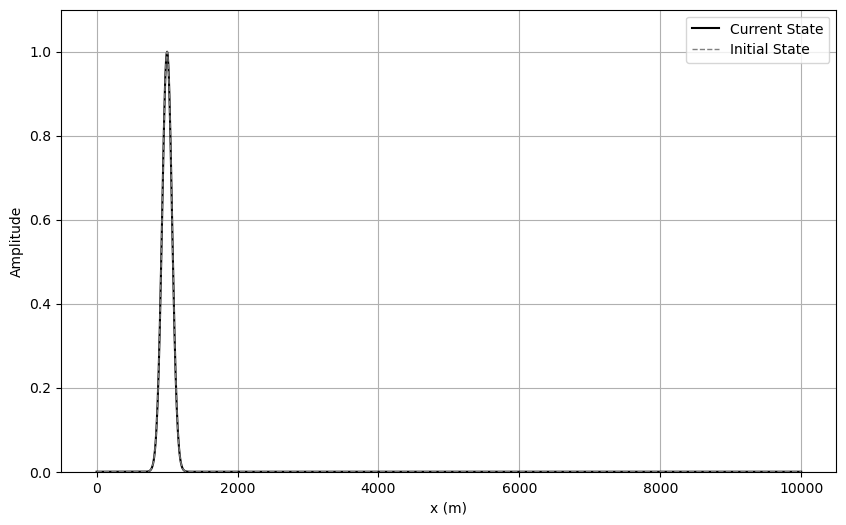

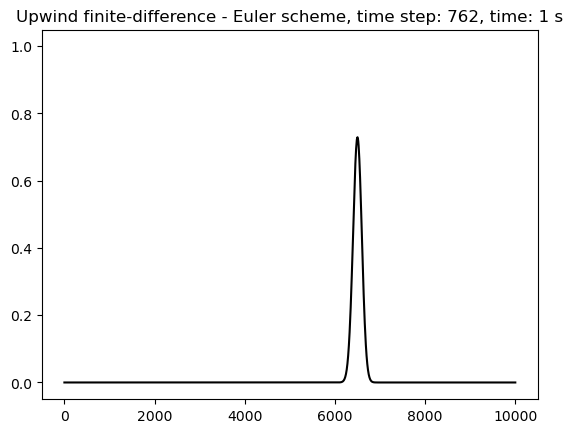

In [7]:
# Advection Equation - Euler Scheme

# Plot the initial condition for comparison
plt.figure(figsize=(10, 6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")
plt.xlabel("x (m)")
plt.ylabel("Amplitude")
if fd_type == "upwind":
    title = "Upwind finite-difference - Euler scheme"
elif fd_type == "centered":
    title = "Centered finite-difference- Euler scheme"
else:
    raise ValueError("fd_type must be 'forward' or 'centered'")

plt.grid()
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()

# Here we start the actual time extrapolation
# Calculate the space derivative of u(x) and write it into du(x)
for i in range(nt):
    du[:] = 0.0
    for j in range(1, nx - 1):
        if fd_type == "upwind":
            du[j] = (u[j] - u[j - 1]) / dx
        elif fd_type == "centered":
            du[j] = (u[j + 1] - u[j - 1]) / (2.0 * dx)

    # time extrapolation scheme (Euler)
    unew = u - dt * v * du

    # The new presence is the current future!
    u = unew

    # Update plot.
    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)
        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()
plt.ioff()

#### Predictor-Corrector Method
The predictor-corrector method or Heun's method is obtained from the Euler method and the trapezoidal rule. Let's  rewrite the advection equation as
$$
\partial_t u(x,t) = f(u,t) = - v\partial_x u(x,t) 
$$
where $u$ is the solution velocity field, $v$ is the speed and $f$ is a linear operator. 

The first-order Euler scheme corresponds to 
$$
\tilde{u} = u(x, t+\Delta t) = u(x,t) + \Delta t f(u, t)
$$

Once we get the partial derivative of velocity field $\partial_x u(x,t)$ form the operator $f$, calculated using the upwind finite difference scheme, the Heun's method is applied as follows:

* First the predictor is evaluated: it calculates the linear operator $f$ in the previous time step. 
$$
  k1 = f(u,t) = f(u^n, t^n) 
$$
* Second the corrector: calculates the linear operator in the current time step, which is unknown and therefore is calculated using the expression obtained form the first-order Euler scheme. 
$$
 k2 = f(\tilde{u}, t+ \Delta t) = f(\tilde{u}^{n+1}, t^{n+1})  
$$
* Finally: improve the initial guess using trapezoidal rule and get a solution for the velocity field
$$
u^{n+1} = u^n + \frac{\Delta t}{2}(k1 + k2)
$$

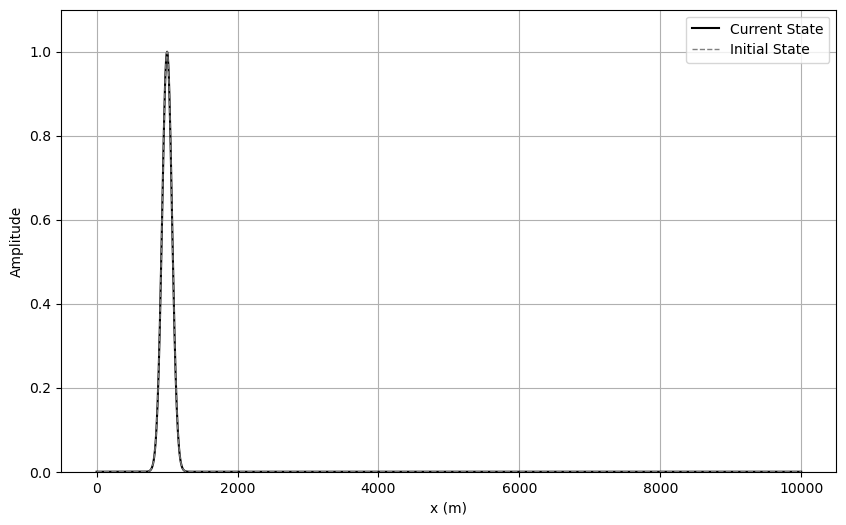

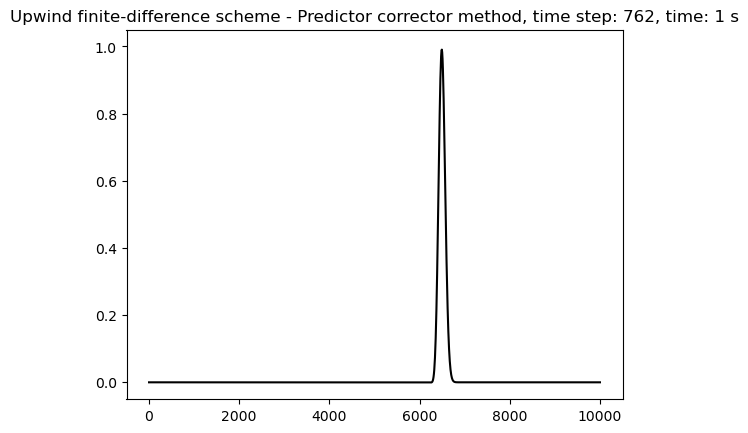

In [8]:
# Advection Equation - Predictor Corrector Scheme

# Initial conditions
u = sx
unew = np.zeros(nx)
du = np.zeros(nx)
k1 = np.zeros(nx)
k2 = np.zeros(nx)
q = np.zeros(nx)


# Plot the initial condition for comparison
# Initialize figures
plt.figure(figsize=(10, 6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")

plt.xlabel("x (m)")
plt.ylabel("Amplitude")
title = "Upwind finite-difference scheme - Predictor corrector method"

plt.grid()
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()
# # Here we start the actual time extrapolation, the task for you is to calculate
# the space derivative of u(x) and write it into du(x)

for i in range(nt):
    du[:] = 0.0
    # Calculate the spatial derivative using the upwind approach
    for j in range(1, nx - 1):
        du[j] = (u[j] - u[j - 1]) / dx

    # time extrapolation
    # predictor
    k1 = v * du
    q = u - dt * v * du

    unew = q

    # corrector
    for j in range(1, nx - 1):
        du[j] = (q[j + 1] - q[j]) / dx
    k2 = v * du

    # predictor corrector extrapolation
    unew = u - 0.5 * dt * (k1 + k2)

    # The new presence is the current future!
    u = unew

    # Update plot if desired.
    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)

        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()


plt.ioff()

#### McCormack Scheme
The McCormack scheme is also used to solve first order hyperbolic partial differential equations and is considered a second order finite difference method. Its algorithm is the following: 
* First using the Euler method with an upwind approximation to calculate the solution $u_i^{\overline{n+1}}$
$$
u_i^{\overline{n+1}} = u_i^n - v \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n)
$$
* And second compute the corrector and update the solution. 
$$
u_i^{n+1} = \frac{u_i^n + u_i^\overline{n+1}}{2} - v \frac{\Delta t}{2 \Delta x}(u_{i+1}^\overline{n+1} - u_{i}^\overline{n+1}) 
$$

The first term in the above equation is an average of the solution calculated from the Euler method $u_i^{\overline{n+1}}$ with the current one $u_i^n$. And the second term is the forward finite differences approximation with the $u_i^{\overline{n+1}}$ solution from the Euler approximation.

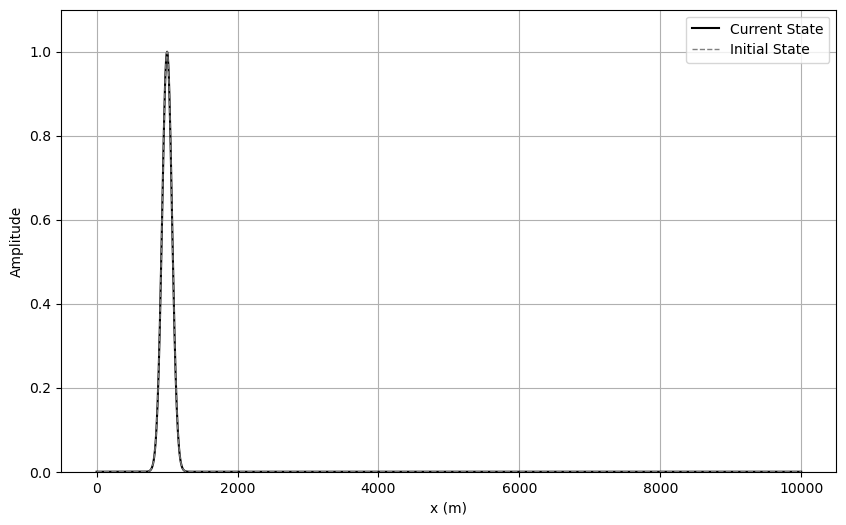

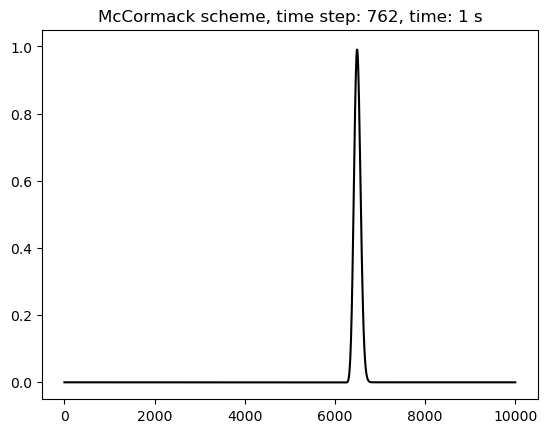

In [9]:
# Advection Equation - McCormack Scheme

# Initial conditions
u = sx
unew = np.zeros(nx)
du = np.zeros(nx)
k1 = np.zeros(nx)
k2 = np.zeros(nx)
q = np.zeros(nx)


# Plot the initial condition for comparison
# Initialize figures
plt.figure(figsize=(10, 6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")

plt.xlabel("x (m)")
plt.ylabel("Amplitude")
title = "McCormack scheme"

plt.grid()
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()
# # Here we start the actual time extrapolation, the task for you is to calculate
# the space derivative of u(x) and write it into du(x)

for i in range(nt):
    du[:] = 0.0
    # Calculate the spatial derivative using the upwind approach
    for j in range(1, nx - 1):
        du[j] = (u[j] - u[j - 1]) / dx

    # time extrapolation
    # 1st step
    q = u - dt * v * du

    # 2nd step
    for j in range(1, nx - 1):
        du[j] = (q[j + 1] - q[j]) / dx

    # update
    unew = 0.5 * (u + q) - v * dt * 0.5 * du
    # The new presence is the current future!
    u = unew

    # Update plot if desired.
    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)

        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()


plt.ioff()

#### Lax Wendroff Scheme
Finally the Lax Wendroff scheme is also used to solve hyperbolic partial differential equations and is considered a second order method in the space and time domain. It is found using a Taylor approximation of $u_i^{n+1}$,
$$
u_i^{n+1} \approx u_i^{n} - \Delta t v \frac{\partial u}{\partial x}\Biggr\vert_i^n + \Delta t^2 v^2 \frac{\partial^2 u}{\partial^2 x} \Biggr\vert_i^n + ... 
$$

Then the solution for each time step of the velocity field is 
$$
u_i^{n+1} = u_i^n - \frac{\Delta t}{2 \Delta x} v (u^n_{i+1}- u^n_{i-1}) + \frac{\Delta t^2}{2 \Delta x^2} v^2 (u_{i+1}^n - 2 u_i^n + u_{i-1}^n)
$$

which uses a centred finite differences scheme. 

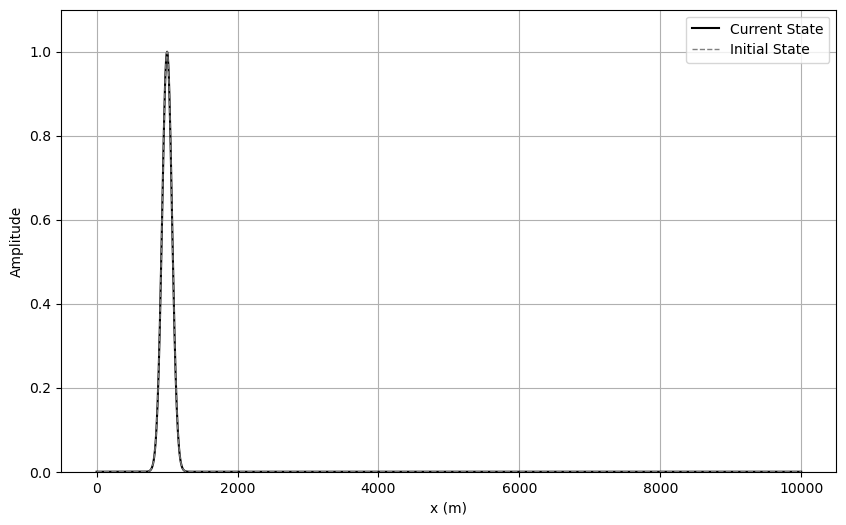

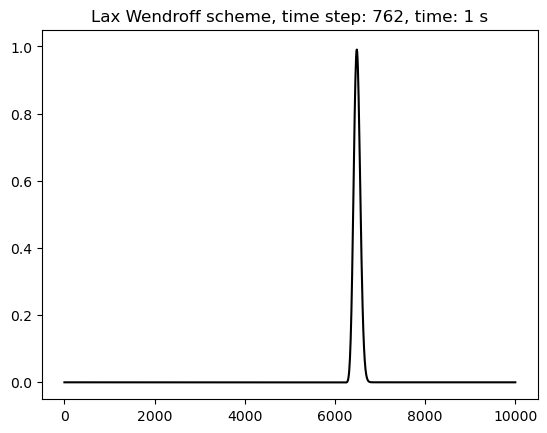

In [10]:
# Advection Equation - Lax Wendroff Scheme

# Initial conditions
u = sx
q = np.zeros(nx)
du = np.zeros(nx)

# plot the initial condition for comparison
# Initialize figures
plt.figure(figsize=(10, 6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")
plt.xlabel("x (m)")
plt.ylabel("Amplitude")
title = "Lax Wendroff scheme"
plt.grid()
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()
# Lax Wendroff  scheme
for i in range(1, nt):
    # (central diff)
    for j in range(1, nx - 1):
        # q =  a*(v[j+1]-2.*v[j]+v[j-1])
        # vnew[j]=v[j] + q
        du[j] = (u[j + 1] - u[j - 1]) / (2.0 * dx)
        q[j] = dt**2 / (2.0 * dx**2) * v**2 * (u[j + 1] - 2.0 * u[j] + u[j - 1])
    # time extrapolation scheme (Euler)
    unew = u - dt * v * du + q
    u = unew
    # time extrapolation

    # Plotting

    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)
        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()
plt.ioff()